# HOG Features

## import required packages
The following code is based on https://github.com/shravankumar147/gtsrb-smai/blob/master/docs/MLP%2BClassfier%2Bon%2BHOG%2BFeatures/MLP%20Classfier%20on%20HOG%20Features.md with modificaitons for Python3 support.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# helper functions 

# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def get_csv(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]


def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box')
    plt.show()
    
# Functions for testimages    
def loadtestimages_from_path(testpath):
    print("[INFO] reading all test images from directory")
    gtFile = get_csv(testpath)
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';', quoting=csv.QUOTE_NONE)
    next(reader)
    testfiles = list(reader)
    timg = []
    testimg = []
    tlbl = []
    for i in testfiles:
    #     print (i[0],i[-1])
        fname = os.path.join(testpath,i[0])
        timg.append(fname)
        tim = plt.imread(fname)
        testimg.append(tim)
        label = i[-1]
        tlbl.append(label)
    np.save("Image_n_Labels/testimagenames.npy",timg)
    np.save("Image_n_Labels/testimages.npy",testimg)
    np.save("Image_n_Labels/testimagelabels.npy",tlbl)
    return timg, testimg, tlbl
    
def loadtestimages_from_npy():
    print("[INFO] loading testing images")
    timg = np.load("Image_n_Labels/testimagenames.npy", allow_pickle=True)
    testimg = np.load("Image_n_Labels/testimages.npy", allow_pickle=True)
    tlbl = np.load("Image_n_Labels/testimagelabels.npy")
    return timg, testimg, tlbl

## Read and Save Training Data

In [4]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy", allow_pickle=True)
    y = np.load("Image_n_Labels/trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../GTSRB/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


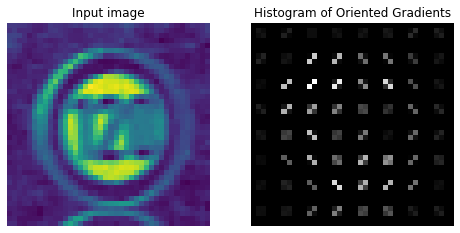

1568


In [51]:
# simple test on single image for HoG features
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
# gI2 = cv2.resize(grayim, (40, 40), interpolation = cv2.INTER_CUBIC)
# Original parms
# (H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
#     cells_per_block=(2, 2), transform_sqrt=True, visualise=True)

# HOG 2 from http://www.lara.prd.fr/_media/users/ijcnn.pdf
(H, hogImage) = feature.hog(gI1, orientations=8, pixels_per_cell=(5,5),
                            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(gI1, hogImage)
print(len(H))

## Read and Save Test Data

In [6]:
testpath="../GTSRB/Final_Test/Images/"
if os.path.isfile("Image_n_Labels/testimagenames.npy") and os.path.isfile("Image_n_Labels/testimages.npy") and os.path.isfile("Image_n_Labels/testimagelabels.npy"):
    timg, testimg, tlbl = loadtestimages_from_npy()
else:
    timg, testimg, tlbl = loadtestimages_from_path(testpath)

[INFO] loading testing images


## Process and Save HOG For Training

In [52]:
if os.path.isfile("HoGFeatures/HoG2features.npy") & os.path.isfile("HoGFeatures/HoG2visualize.npy") :
    print("loading from file ... ")
    hogfeat = np.load("HoGFeatures/HoG2features.npy")
    hogviz = np.load("HoGFeatures/HoG2visualize.npy")
    
    print("HoG features are loaded from HoG2features.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("HoG2features.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        # TODO: try HOG2 from http://www.lara.prd.fr/_media/users/ijcnn.pdf
        (H_5x5, hogImage) = feature.hog(grayim, orientations=8, pixels_per_cell=(5, 5),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
#         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_5x5)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoG2features.npy", Hfeat)
    np.save("HoGFeatures/HoG2visualize.npy", Hviz)
    print("HoG2features.npy are saved")  
    print("HoG2visualize.npy are saved")

HoG2features.npy does not found
[INFO] processed 1000/39209
[INFO] processed 2000/39209
[INFO] processed 3000/39209
[INFO] processed 4000/39209
[INFO] processed 5000/39209
[INFO] processed 6000/39209
[INFO] processed 7000/39209
[INFO] processed 8000/39209
[INFO] processed 9000/39209
[INFO] processed 10000/39209
[INFO] processed 11000/39209
[INFO] processed 12000/39209
[INFO] processed 13000/39209
[INFO] processed 14000/39209
[INFO] processed 15000/39209
[INFO] processed 16000/39209
[INFO] processed 17000/39209
[INFO] processed 18000/39209
[INFO] processed 19000/39209
[INFO] processed 20000/39209
[INFO] processed 21000/39209
[INFO] processed 22000/39209
[INFO] processed 23000/39209
[INFO] processed 24000/39209
[INFO] processed 25000/39209
[INFO] processed 26000/39209
[INFO] processed 27000/39209
[INFO] processed 28000/39209
[INFO] processed 29000/39209
[INFO] processed 30000/39209
[INFO] processed 31000/39209
[INFO] processed 32000/39209
[INFO] processed 33000/39209
[INFO] processed 340

## Process and Save HOG For Testing

In [53]:
if os.path.isfile("HoGFeatures/HoG2features_test.npy") and os.path.isfile("HoGFeatures/HoG2visualize_test.npy") :
    hogfeat_test = np.load("HoGFeatures/HoG2features_test.npy")
    hogviz_test = np.load("HoGFeatures/HoG2visualize_test.npy")
    
    print("HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test")
else:
    print("HoG2features_test.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(testimg)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(testimg)))
        I = testimg[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_5x5, hogImage) = feature.hog(grayim, orientations=8, pixels_per_cell=(5, 5),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
    #         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_5x5)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoG2features_test.npy", Hfeat)
    np.save("HoGFeatures/HoG2visualize_test.npy", Hviz)
    print("HoG2features_test.npy are saved")  
    print("HoG2visualize_test.npy are saved")

HoGfeatures_test.npy does not found
[INFO] processed 1000/12630
[INFO] processed 2000/12630
[INFO] processed 3000/12630
[INFO] processed 4000/12630
[INFO] processed 5000/12630
[INFO] processed 6000/12630
[INFO] processed 7000/12630
[INFO] processed 8000/12630
[INFO] processed 9000/12630
[INFO] processed 10000/12630
[INFO] processed 11000/12630
[INFO] processed 12000/12630
HoG2features_test.npy are saved
HoG2visualize_test.npy are saved


## Convert datatype to float for both training and testing data

In [55]:
# Training
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")

# Testing
X_t = np.array(hogfeat_test).astype("float")
tlbl = np.array(tlbl).astype("float")


## Create Train, Validation, Test 

In [60]:
features = Xhog
labels = y
testData = X_t
testLabels = tlbl
# (trainData, valData, trainLabels, valLabels) = train_test_split(features, labels,
#     test_size=0.1, random_state=84)
trainData = features
trainLabels = y

## Model Training

In [11]:
from sklearn import neighbors

In [49]:
clf = neighbors.KNeighborsClassifier()
clf.fit(trainData, trainLabels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [12]:
from sklearn import svm

In [70]:
clf_svm = svm.SVC()
clf_svm.fit(trainData, trainLabels)

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
save = False
if save:
    with open('knn_model.pickle', 'wb') as handle:
        pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('svm_model.pickle', 'wb') as handle:
        pickle.dump(clf_svm, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('svm_linear_model.pickle', 'wb') as handle:
        pickle.dump(clf_svm_linear, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('knn_model.pickle', 'rb') as handle:
        clf = pickle.load(handle)
    
    with open('svm_model.pickle', 'rb') as handle:
        clf_svm = pickle.load(handle)
        
    with open('svm_linear_model.pickle', 'rb') as handle:
        clf_svm_linear = pickle.load(handle)

In [22]:
clf_svm_linear = svm.LinearSVC(max_iter=10000)
clf_svm_linear.fit(trainData, trainLabels)
with open('svm_linear_model.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear, handle, protocol=pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: 

In [23]:
clf_svm_linear2 = svm.LinearSVC(max_iter=100000)
clf_svm_linear2.fit(trainData, trainLabels)
with open('svm_linear_model_2.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
clf_svm_linear3 = svm.LinearSVC(max_iter=10000, loss='hinge')
clf_svm_linear3.fit(trainData, trainLabels)
with open('svm_linear_model_3.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
clf_svm_linear4 = svm.LinearSVC(max_iter=10000, tol=1e-5)
clf_svm_linear4.fit(trainData, trainLabels)
with open('svm_linear_model_4.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
clf_svm_linear5 = svm.LinearSVC(max_iter=100000, tol=1e-5)
clf_svm_linear5.fit(trainData, trainLabels)
with open('svm_linear_model_5.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
from sklearn import ensemble

In [33]:
clf_rfc = ensemble.RandomForestClassifier()
clf_rfc.fit(trainData, trainLabels)
with open('rfc_model.pickle', 'wb') as handle:
    pickle.dump(clf_rfc, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
clf_rfc2 = ensemble.RandomForestClassifier(n_estimators=100)
clf_rfc2.fit(trainData, trainLabels)
with open('rfc_model2.pickle', 'wb') as handle:
    pickle.dump(clf_rfc2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
clf_rfc3 = ensemble.RandomForestClassifier(n_estimators=200)
clf_rfc3.fit(trainData, trainLabels)
with open('rfc_model3.pickle', 'wb') as handle:
    pickle.dump(clf_rfc3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
clf_rfc4 = ensemble.RandomForestClassifier(n_estimators=500)
clf_rfc4.fit(trainData, trainLabels)
with open('rfc_model4.pickle', 'wb') as handle:
    pickle.dump(clf_rfc4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
clf_rfc5 = ensemble.RandomForestClassifier(min_samples_split=500, n_estimators=500, n_jobs=8)
clf_rfc5.fit(trainData, trainLabels)
with open('rfc_model5.pickle', 'wb') as handle:
    pickle.dump(clf_rfc5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
clf_rfc6 = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=8)
clf_rfc6.fit(trainData, trainLabels)
with open('rfc_model6.pickle', 'wb') as handle:
    pickle.dump(clf_rfc6, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# With HOG2
clf_rfc7 = ensemble.RandomForestClassifier(n_estimators=500, n_jobs=8)
clf_rfc7.fit(trainData, trainLabels)
with open('rfc_model7.pickle', 'wb') as handle:
    pickle.dump(clf_rfc7, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluation

In [20]:
from sklearn.metrics import classification_report,accuracy_score

In [51]:
predicted_labels = clf.predict(testData)

In [68]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels)))
print('\n')
print(classification_report(testLabels, predicted_labels))

Accuracy: 0.7969912905779889


              precision    recall  f1-score   support

         0.0       0.72      0.38      0.50        60
         1.0       0.78      0.64      0.70       720
         2.0       0.70      0.70      0.70       750
         3.0       0.59      0.66      0.62       450
         4.0       0.77      0.90      0.83       660
         5.0       0.48      0.67      0.56       630
         6.0       0.89      0.73      0.80       150
         7.0       0.73      0.69      0.71       450
         8.0       0.66      0.70      0.68       450
         9.0       0.92      0.78      0.84       480
        10.0       0.84      0.93      0.88       660
        11.0       0.79      0.75      0.77       420
        12.0       1.00      1.00      1.00       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.91      0.95       270
        15.0       0.99      0.95      0.97       210
        16.0       0.91      0.98      0.94       

In [72]:
predicted_labels_svm = clf_svm.predict(testData)

In [73]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm))

Accuracy: 0.7781472684085511


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.72      0.73      0.72       720
         2.0       0.51      0.96      0.67       750
         3.0       0.98      0.36      0.53       450
         4.0       0.92      0.94      0.93       660
         5.0       0.66      0.63      0.64       630
         6.0       0.66      0.65      0.65       150
         7.0       0.93      0.80      0.86       450
         8.0       0.86      0.86      0.86       450
         9.0       0.91      0.89      0.90       480
        10.0       0.87      0.95      0.91       660
        11.0       0.52      0.94      0.67       420
        12.0       0.98      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.87      0.93       270
        15.0       0.99      0.91      0.95       210
        16.0       1.00      0.67      0.80       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
predicted_labels_svm_linear = clf_svm_linear.predict(testData)

In [ ]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear))

In [27]:
predicted_labels_svm_linear2 = clf_svm_linear2.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear2)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear2))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [28]:
predicted_labels_svm_linear3 = clf_svm_linear3.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear3)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear3))

Accuracy: 0.9208234362628662


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.90      0.86      0.88       720
         2.0       0.85      0.93      0.89       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.82      0.81      0.82       630
         6.0       0.83      0.77      0.80       150
         7.0       0.94      0.91      0.92       450
         8.0       0.84      0.85      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.90      0.92       420
        12.0       0.98      0.99      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.90      1.00      0.95       210
        16.0       0.95      0.99      0.97       

In [29]:
predicted_labels_svm_linear4 = clf_svm_linear4.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear4)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear4))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [30]:
predicted_labels_svm_linear5 = clf_svm_linear5.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear5)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear5))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [34]:
predicted_labels_rfc = clf_rfc.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc))

Accuracy: 0.8401425178147268


              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62        60
         1.0       0.71      0.82      0.76       720
         2.0       0.68      0.89      0.77       750
         3.0       0.79      0.73      0.76       450
         4.0       0.86      0.91      0.89       660
         5.0       0.65      0.67      0.66       630
         6.0       0.85      0.61      0.71       150
         7.0       0.83      0.84      0.84       450
         8.0       0.77      0.72      0.74       450
         9.0       0.87      0.95      0.91       480
        10.0       0.93      0.93      0.93       660
        11.0       0.76      0.89      0.82       420
        12.0       0.96      0.98      0.97       690
        13.0       0.98      0.99      0.99       720
        14.0       0.95      0.87      0.91       270
        15.0       0.95      0.91      0.93       210
        16.0       0.99      0.89      0.94       

In [38]:
predicted_labels_rfc2 = clf_rfc2.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc2)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc2))

Accuracy: 0.9219319081551861


              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        60
         1.0       0.91      0.89      0.90       720
         2.0       0.82      0.96      0.89       750
         3.0       0.94      0.80      0.86       450
         4.0       0.91      0.95      0.93       660
         5.0       0.79      0.87      0.83       630
         6.0       0.88      0.71      0.79       150
         7.0       0.92      0.92      0.92       450
         8.0       0.88      0.87      0.88       450
         9.0       0.94      0.99      0.96       480
        10.0       0.97      0.98      0.98       660
        11.0       0.86      0.94      0.90       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.94      0.97       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.93      0.97       

In [39]:
predicted_labels_rfc3 = clf_rfc3.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc3)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc3))

Accuracy: 0.9287410926365796


              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        60
         1.0       0.90      0.91      0.91       720
         2.0       0.84      0.97      0.90       750
         3.0       0.96      0.79      0.87       450
         4.0       0.91      0.95      0.93       660
         5.0       0.82      0.90      0.86       630
         6.0       0.88      0.71      0.79       150
         7.0       0.93      0.93      0.93       450
         8.0       0.89      0.88      0.88       450
         9.0       0.94      0.99      0.96       480
        10.0       0.96      0.99      0.97       660
        11.0       0.85      0.94      0.89       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.97      0.98       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.94      0.97       

In [40]:
predicted_labels_rfc4 = clf_rfc4.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc4)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc4))

Accuracy: 0.9323832145684877


              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72        60
         1.0       0.90      0.90      0.90       720
         2.0       0.86      0.97      0.91       750
         3.0       0.98      0.81      0.89       450
         4.0       0.92      0.96      0.94       660
         5.0       0.83      0.92      0.87       630
         6.0       0.84      0.69      0.76       150
         7.0       0.93      0.94      0.94       450
         8.0       0.90      0.89      0.89       450
         9.0       0.95      0.99      0.97       480
        10.0       0.96      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.98      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.96      0.98       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.95      0.98       

In [42]:
predicted_labels_rfc5 = clf_rfc5.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc5)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc5))

Accuracy: 0.8468725257323833


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.80      0.81      0.81       720
         2.0       0.76      0.95      0.84       750
         3.0       0.88      0.79      0.84       450
         4.0       0.82      0.92      0.87       660
         5.0       0.75      0.77      0.76       630
         6.0       0.92      0.47      0.62       150
         7.0       0.81      0.93      0.86       450
         8.0       0.81      0.78      0.79       450
         9.0       0.83      0.97      0.89       480
        10.0       0.89      0.98      0.93       660
        11.0       0.70      0.93      0.80       420
        12.0       0.96      1.00      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.99      0.89      0.93       270
        15.0       0.96      0.99      0.97       210
        16.0       1.00      0.79      0.88       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
predicted_labels_rfc6 = clf_rfc6.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc6)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc6))

Accuracy: 0.9338083927157561


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        60
         1.0       0.90      0.91      0.91       720
         2.0       0.86      0.98      0.91       750
         3.0       0.97      0.80      0.87       450
         4.0       0.93      0.96      0.95       660
         5.0       0.85      0.93      0.88       630
         6.0       0.85      0.70      0.77       150
         7.0       0.93      0.92      0.93       450
         8.0       0.88      0.90      0.89       450
         9.0       0.94      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.94      0.97       270
        15.0       0.98      0.99      0.98       210
        16.0       1.00      0.95      0.97       

In [59]:
predicted_labels_rfc7 = clf_rfc7.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc7)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc7))

Accuracy: 0.9347585114806017


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        60
         1.0       0.91      0.91      0.91       720
         2.0       0.87      0.97      0.92       750
         3.0       0.97      0.81      0.88       450
         4.0       0.93      0.96      0.95       660
         5.0       0.84      0.93      0.88       630
         6.0       0.86      0.73      0.79       150
         7.0       0.94      0.94      0.94       450
         8.0       0.88      0.89      0.88       450
         9.0       0.94      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.89      0.94      0.92       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.96      0.98       270
        15.0       0.98      0.99      0.98       210
        16.0       1.00      0.95      0.97       

## More Experiments

In [ ]:
for i in [500, 1000, 2000, 5000]:
    clf_rfc_high = ensemble.RandomForestClassifier(n_estimators=i, n_jobs=8)
    clf_rfc_high.fit(trainData, trainLabels)
    with open('rfc_model_'+ str(i) + '.pickle', 'wb') as handle:
        pickle.dump(clf_rfc_high, handle, protocol=pickle.HIGHEST_PROTOCOL)
    predicted_labels_rfc_high = clf_rfc_high.predict(testData)
    print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_high)))
    print('\n')
    print(classification_report(testLabels, predicted_labels_rfc_high))

Accuracy: 0.9335708630245447


              precision    recall  f1-score   support

         0.0       1.00      0.52      0.68        60
         1.0       0.91      0.91      0.91       720
         2.0       0.85      0.98      0.91       750
         3.0       0.97      0.81      0.88       450
         4.0       0.93      0.96      0.94       660
         5.0       0.85      0.91      0.88       630
         6.0       0.83      0.71      0.77       150
         7.0       0.92      0.94      0.93       450
         8.0       0.88      0.88      0.88       450
         9.0       0.95      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.94      0.97       270
        15.0       0.98      0.99      0.99       210
        16.0       1.00      0.96      0.98       